In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred
import api_key 

plt.style.use("fivethirtyeight")  # use fivethirtyeight style
pd.set_option.display_max_columns = 500  # display all columns
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # change default colors
fred_key = api_key.fred_key  # fred api key

create fred object

In [3]:
fred = Fred(api_key=fred_key)
fred

Search for data

In [4]:
sp_search = fred.search("S&P", order_by="popularity")

Pull data

In [5]:
sp500 = fred.get_series("SP500")

Pull Multiple Series

In [6]:
unemployment_results_df = fred.search(
    "unemployment rate state", filter=("frequency", "Monthly")
)
unemployment_results_df = unemployment_results_df.query(
    'seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"'
)
unemployment_results_df = unemployment_results_df.loc[
    unemployment_results_df["title"].str.contains("Unemployment Rate in")
]

In [7]:
all_results = []

for myid in unemployment_results_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

In [8]:
unemp_states = pd.concat(all_results, axis=1).drop(
    [
        "LASMT261982000000003",
        "LASMT391746000000003",
        "CMWRUR",
        "CWSTUR",
        "CSOUUR",
        "CNERUR",
        "CNEWUR",
        "PRUR",
    ],
    axis=1,
)
id_to_state = (
    unemployment_results_df["title"].str.replace("Unemployment Rate in ", "").to_dict()
)
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns]

In [9]:
px.line(unemp_states)

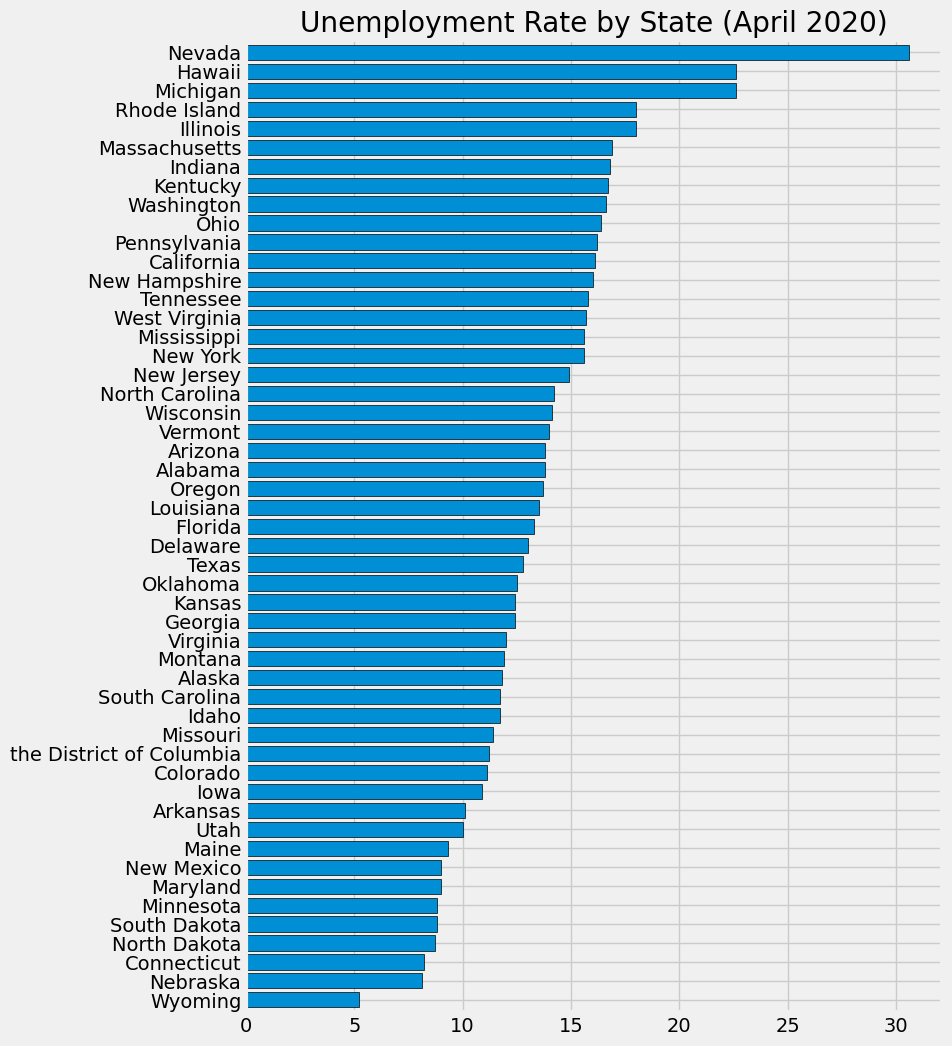

In [10]:
# apr 2020 unemployment rate per state
ax = (
    unemp_states.loc[unemp_states.index == "2020-04-01"]
    .T.sort_values(by="2020-04-01")
    .plot(
        kind="barh",
        figsize=(8, 12),
        width=0.8,
        edgecolor="black",
        title="Unemployment Rate by State (April 2020)",
    )
)
ax.legend().remove()
plt.show()

In [11]:
# participation rate
part_df = fred.search("participation rate state", filter=("frequency", "Monthly"))
part_df = part_df.query(
    'seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"'
)
part_df = part_df.loc[part_df["title"].str.contains("Participation Rate for ")]

In [12]:
part_id_to_state = (
    part_df["title"].str.replace("Labor Force Participation Rate for ", "").to_dict()
)

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [13]:
unemp_states.rename(
    columns={"the District of Columbia": "District Of Columbia"}, inplace=True
)

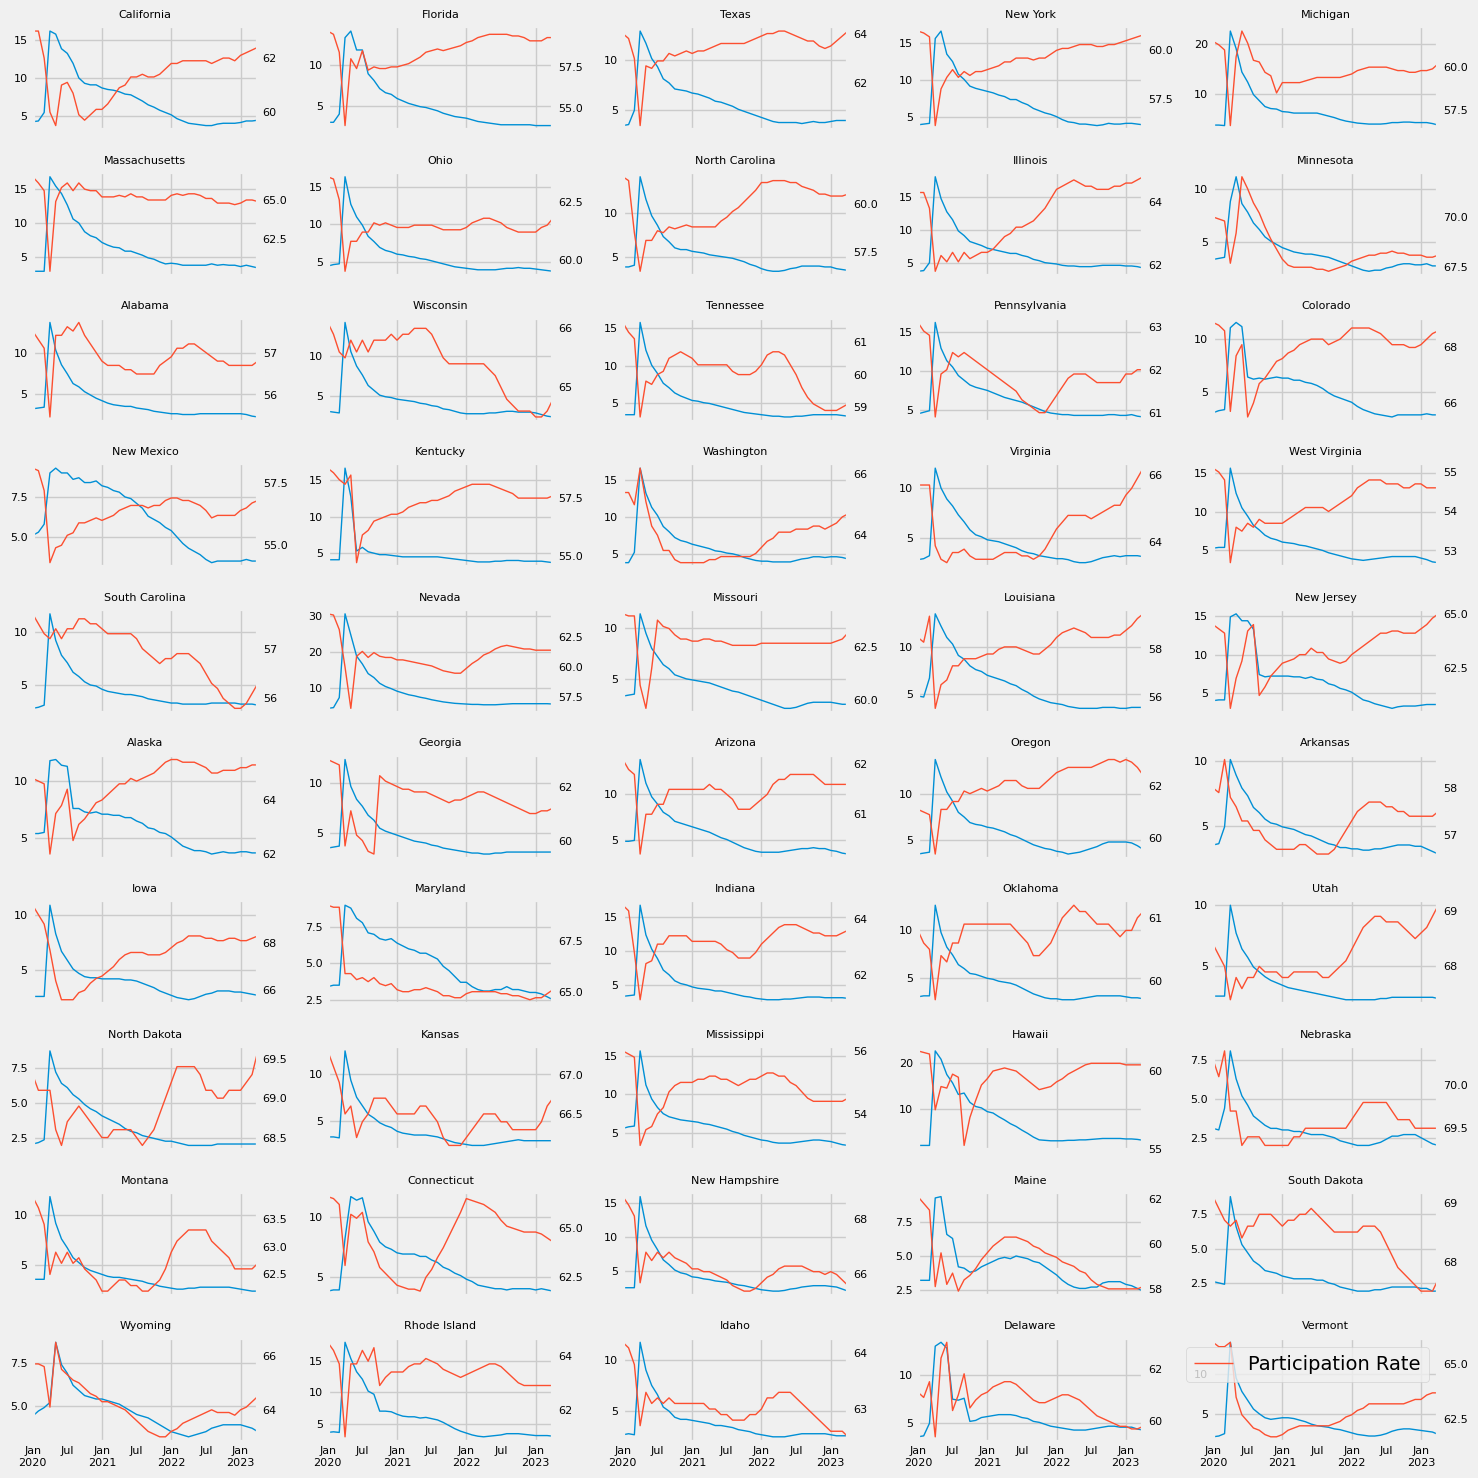

In [20]:
# unemployment rate vs participation rate since 2020

fig, axs = plt.subplots(10, 5, figsize=(15, 15), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state == "District Of Columbia":
        continue
    ax = axs[i]
    ax2 = ax.twinx()
    unemp_states.query("index >= 2020")[state].plot(
        ax=ax, label="Unemployment Rate", color=color_pal[0], linewidth=1, fontsize=8
    )
    part_states.query("index >= 2020")[state].plot(
        ax=ax2, label="Participation Rate", color=color_pal[1], linewidth=1, fontsize=8
    )
    ax2.grid(False)
    ax.set_title(state, fontsize=8)
    i += 1
    
plt.tight_layout()
plt.legend()
plt.show()